# NLP Disaster Tweets | Logistic Regression + DistilBERT (KerasNLP)

In this notebook, we aim to solve the **Disaster Tweets Classification** task by comparing two models:
- **Logistic Regression** (baseline model)
- **DistilBERT** (pretrained model from KerasNLP)

We will load the dataset, preprocess the text, train both models, evaluate their performances, and generate a submission file based on the best model.


In [1]:
!pip install keras-nlp --upgrade
!pip install keras-core --upgrade

# List all files in the Kaggle input directory to verify available datasets
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.1/792.1 kB 23.8 MB/s eta 0:00:00
  Attempting uninstall: keras-hub
    Found existing installation: keras-hub 0.18.1
    Uninstalling keras-hub-0.18.1:
      Successfully uninstalled keras-hub-0.18.1
  Attempting uninstall: keras-nlp
    Found existing installation: keras-nlp 0.18.1
    Uninstalling keras-nlp-0.18.1:
      Successfully uninstalled keras-nlp-0.18.1
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/3/config.json
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/3/tokenizer.json
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/3/metadata.json
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/3/model.weights.h5
/kaggle/input/distil_bert/keras/distil_bert_base_en_uncased/3/assets/tokenizer/vocabulary.txt


In [2]:
# Importing Required Libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
sns.set()

# Load the Data and Visualisation 
First, let's load and explore the dataset!

In [3]:
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

print(train_df.shape)
print(test_df.shape)

(7613, 5)
(3263, 4)


In [4]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Target Distribution

Before training, it's important to understand the distribution of the target classes.  
Let's visualize how many disaster vs non-disaster tweets we have in the training dataset.


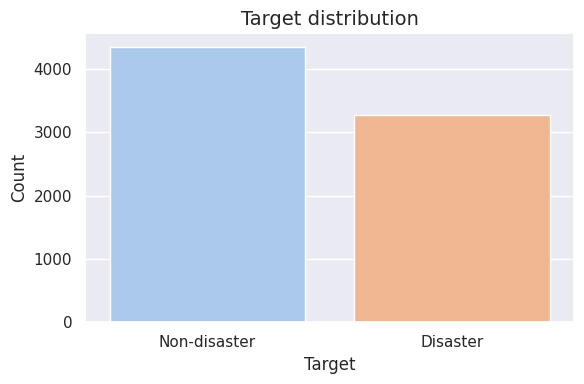

target
0    4342
1    3271
Name: count, dtype: int64

In [5]:
plt.figure(figsize=(6, 4))
sns.countplot(data=train_df, x="target", palette="pastel")
plt.title("Target distribution", fontsize=14)
plt.xlabel("Target", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks([0, 1], ['Non-disaster', 'Disaster'])
plt.tight_layout()
plt.show()

train_df.target.value_counts()

# Model 1: Logistic Regression

In this section, we will build a **Logistic Regression** model as a strong baseline for classifying disaster tweets.  



## Data Preprocessing: Train and Test

For our training dataset, we apply the following preprocessing steps:
- Drop unnecessary columns (`id`, `location`)
- Fill missing values in `keyword` with the placeholder `'unknown'`
- Remove duplicate tweets based on the `text` column

This ensures our data is clean and consistent before moving into feature extraction.

In [6]:
# Check for missing values in the training and test datasets
print(train_df.isnull().sum())
print(' ')
print(test_df.isnull().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
 
id             0
keyword       26
location    1105
text           0
dtype: int64


In [7]:
# Drop duplicate tweets, unnecessary columns, and fill missing 'keyword' values
df_train = train_df.copy()
df_train = df_train.drop_duplicates(subset='text')
df_train = df_train.drop(['id', 'location'], axis=1)
df_train['keyword'] = df_train['keyword'].fillna('unknown')

df_train.head()

,keyword,text,target
0,unknown,Our Deeds are the Reason of this #earthquake M...,1
1,unknown,Forest fire near La Ronge Sask. Canada,1
2,unknown,All residents asked to 'shelter in place' are ...,1
3,unknown,"13,000 people receive #wildfires evacuation or...",1
4,unknown,Just got sent this photo from Ruby #Alaska as ...,1


 Now to improve model performance, we clean the tweet texts by:
- Lowercasing all characters
- Removing URLs and mentions
- Simplifying hashtags (e.g., `#fire` → `fire`)
- Removing special characters and numbers
- Removing extra spaces
- Lemmatizing words and removing stopwords

We use a combination of **Regular Expressions (re)** and **spaCy** for efficient text preprocessing.

In [8]:
import re
import spacy

# Load the spaCy English model (with parser and NER disabled for faster performance)
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def clean_text_spacy(text):
    text = text.lower() # Convert to lowercase
    text = re.sub(r"http\S+|www\S+|@\w+", "", text) # Remove URLs and mentions
    text = re.sub(r"#(\w+)", r"\1", text) # Simplify hashtags by removing the '#' symbol
    text = re.sub(r"[^a-zA-Z\s]", "", text) # Remove special characters and numbers
    text = re.sub(r"\s+", " ", text).strip() # Remove extra whitespace
    
    # Lemmatize and remove stopwords, keep tokens longer than 2 characters
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and len(token) > 2]
    
    return " ".join(tokens)

In [9]:
df_train_processed = df_train.copy()
df_train_processed['cleaned_text'] = df_train_processed['text'].apply(clean_text_spacy)

df_train_processed.head()

,keyword,text,target,cleaned_text
0,unknown,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake allah forgive
1,unknown,Forest fire near La Ronge Sask. Canada,1,forest fire near ronge sask canada
2,unknown,All residents asked to 'shelter in place' are ...,1,resident ask shelter place notify officer evac...
3,unknown,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order calif...
4,unknown,Just got sent this photo from Ruby #Alaska as ...,1,get send photo ruby alaska smoke wildfires pou...


## Decoding URL-Encoded Keywords

In the dataset, the `keyword` column sometimes contains **URL-encoded** strings.  
This means that special characters like spaces (`%20`) and plus signs (`+`) are used instead of normal spaces.

For example:
- `forest+fire` ➔ **should be** `forest fire`
- `fatal%20accident` ➔ **should be** `fatal accident`

If we leave them as-is, the model will treat them as completely different tokens, hurting its understanding of the text.  
By decoding these keywords properly, we make sure the information is **consistent**, **readable**, and **helpful** for the model during training.

In [10]:
df_train_processed.keyword.unique()

array(['unknown', 'ablaze', 'accident', 'aftershock',
       'airplane%20accident', 'ambulance', 'annihilated', 'annihilation',
       'apocalypse', 'armageddon', 'army', 'arson', 'arsonist', 'attack',
       'attacked', 'avalanche', 'battle', 'bioterror', 'bioterrorism',
       'blaze', 'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard',
       'blood', 'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail'

In [11]:
# Import utility for decoding URL-encoded keywords
from urllib.parse import unquote

df_train_processed['keyword'] = df_train_processed['keyword'].apply(lambda x: unquote(x.replace('+', ' ')))

# Combine 'keyword' and 'cleaned_text' into a single 'final_text' column
df_train_processed['final_text'] = df_train_processed['keyword'] + ' ' + df_train_processed['cleaned_text']

In [12]:
# Drop unnecessary columns
df_train_processed = df_train_processed.drop(['keyword', 'text', 'cleaned_text'], axis=1)

# Keep only the final features for modeling
df_train_processed = df_train_processed[['final_text', 'target']]

df_train_processed.head()

,final_text,target
0,unknown deed reason earthquake allah forgive,1
1,unknown forest fire near ronge sask canada,1
2,unknown resident ask shelter place notify offi...,1
3,unknown people receive wildfire evacuation ord...,1
4,unknown get send photo ruby alaska smoke wildf...,1


## Feature Extraction and Model Training

Now that the data is cleaned and prepared, we can move to feature extraction and model training.

We will:
- Transform the text into numerical vectors using **TF-IDF** with unigrams and bigrams
- Split the dataset into training and validation sets
- Train a **Logistic Regression** model with class balancing to account for target imbalance


In [13]:
# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(
    max_features=10000,        # Use top 10,000 features
    ngram_range=(1, 2),         # Consider both unigrams and bigrams
    stop_words=None             # Stopwords were already handled manually
)

# Transform the text data into TF-IDF vectors
X = vectorizer.fit_transform(df_train_processed['final_text'])
y = df_train_processed['target']

In [14]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2,        
    stratify=y,           # Stratified split to preserve class distribution
    random_state=42
)

In [15]:
model = LogisticRegression(max_iter=1000, class_weight='balanced')  
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

## Model Evaluation

After training the Logistic Regression model, we evaluate its performance on the validation set.

We use:
- **Classification Report**: to check precision, recall, and F1-score
- **Confusion Matrix**: to visualize the correct and incorrect predictions


In [16]:
y_pred_val = model.predict(X_val)
y_pred_train = model.predict(X_train)

print("Validation classification report:")
print(classification_report(y_val, y_pred_val))
print(' ')
print("Train classification report:")
print(classification_report(y_train, y_pred_train))

Validation classification report:
              precision    recall  f1-score   support

           0       0.83      0.84      0.83       861
           1       0.78      0.76      0.77       640

    accuracy                           0.81      1501
   macro avg       0.80      0.80      0.80      1501
weighted avg       0.81      0.81      0.81      1501

 
Train classification report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.89      3444
           1       0.85      0.84      0.85      2558

    accuracy                           0.87      6002
   macro avg       0.87      0.87      0.87      6002
weighted avg       0.87      0.87      0.87      6002



In [17]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

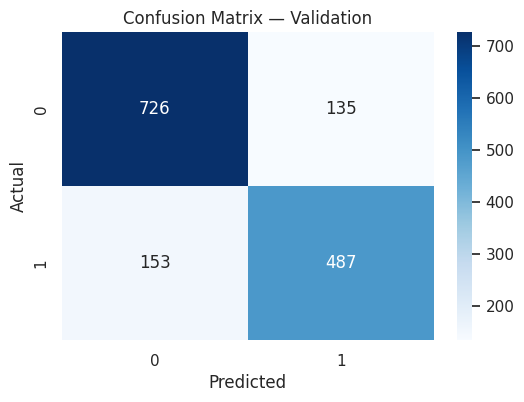

In [18]:
plot_confusion_matrix(y_val, y_pred_val, "Confusion Matrix — Validation")

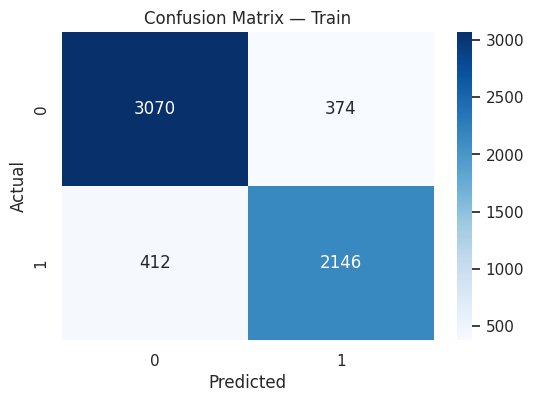

In [19]:
plot_confusion_matrix(y_train, y_pred_train, "Confusion Matrix — Train")

## Summary: Logistic Regression Performance

The Logistic Regression model demonstrated reasonable performance on the disaster tweet classification task with the final `F1-score = 0.81`

Key points:
- Used TF-IDF features based on unigrams and bigrams
- Balanced class weights to address the target imbalance
- Achieved decent precision, recall, and F1-scores
- Most errors occurred between confusing non-disaster and disaster tweets, as seen in the confusion matrix

Now, let's move on to a more powerful approach using a pretrained transformer model — **DistilBERT**!


# Model 2: DistilBERT

In this section, we will fine-tune a **DistilBERT** model on our disaster tweets dataset.

Unlike Logistic Regression, DistilBERT leverages deep contextualized word embeddings, allowing it to better understand the meaning of each tweet. So we don't need to do a lot of preprocessing

Let's start by preparing the data.


In [20]:
import keras_nlp
import keras_core as keras
from keras_nlp.models import DistilBertClassifier
from keras import losses, optimizers

2025-04-28 08:49:47.868173: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745830188.085236      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745830188.149488      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using TensorFlow backend


## Preparing the Dataset for DistilBERT

We apply the same basic preprocessing as before:
- Drop duplicate tweets (train set only)
- Remove unnecessary columns (`id`, `location`)
- Fill missing `keyword` values with a placeholder `'unknown'`
- Decoding URL-Encoded `keyword`

In [21]:
db_train = train_df.copy()
db_test = test_df.copy()

# We apply the same basic preprocessing steps as before for LogReg:
# Preprocessing the training data
db_train = db_train.drop_duplicates(subset='text')
db_train = db_train.drop(['id', 'location'], axis=1)
db_train['keyword'] = db_train['keyword'].fillna('unknown')

# Preprocessing the test data
db_test = db_test.drop(['id', 'location'], axis=1)
db_test['keyword'] = db_test['keyword'].fillna('unknown')

db_train.head()

,keyword,text,target
0,unknown,Our Deeds are the Reason of this #earthquake M...,1
1,unknown,Forest fire near La Ronge Sask. Canada,1
2,unknown,All residents asked to 'shelter in place' are ...,1
3,unknown,"13,000 people receive #wildfires evacuation or...",1
4,unknown,Just got sent this photo from Ruby #Alaska as ...,1


In [22]:
# Decode URL-encoded keywords
db_train['keyword'] = db_train['keyword'].apply(lambda x: unquote(x.replace('+', ' ')))
db_test['keyword'] = db_test['keyword'].apply(lambda x: unquote(x.replace('+', ' ')))

# Combine 'keyword' and 'cleaned_text' again into a single 'final_text' column
db_train['final_text'] = db_train['keyword'] + ' ' + db_train['text']
db_test['final_text'] = db_test['keyword'] + ' ' + db_test['text']

In [23]:
db_train = db_train.drop(['keyword', 'text'], axis=1)
db_test = db_test.drop(['keyword', 'text'], axis=1)

In [24]:
db_train.head()

,target,final_text
0,1,unknown Our Deeds are the Reason of this #eart...
1,1,unknown Forest fire near La Ronge Sask. Canada
2,1,unknown All residents asked to 'shelter in pla...
3,1,"unknown 13,000 people receive #wildfires evacu..."
4,1,unknown Just got sent this photo from Ruby #Al...


In [25]:
db_test.head()

,final_text
0,unknown Just happened a terrible car crash
1,unknown Heard about #earthquake is different c...
2,"unknown there is a forest fire at spot pond, g..."
3,unknown Apocalypse lighting. #Spokane #wildfires
4,unknown Typhoon Soudelor kills 28 in China and...


In [26]:
X_db = db_train['final_text']
y_db = db_train['target']

X_train, X_val, y_train, y_val = train_test_split(X_db, y_db, stratify=y_db, test_size=0.2, random_state=42)

X_test = db_test['final_text']

## Analyzing Token Lengths

Before training the DistilBERT model, it's important to determine an appropriate `sequence_length`.


In [27]:
# Import Hugging Face tokenizer
from transformers import AutoTokenizer
# Load the tokenizer corresponding to DistilBERT
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
# Calculate token lengths for all samples
token_lens = [len(tokenizer(text)['input_ids']) for text in X_db]

print("Mean length:", np.mean(token_lens))
print("Max length:", np.max(token_lens))
print("95% cover:", np.percentile(token_lens, 95))

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Mean length: 34.662534986005596
Max length: 85
95% cover: 54.0


So we can safely use `128 length` or even `55 length` to cover 95% token lenghts and increase our training speed

## Load a DistilBERT model from Keras NLP

We use the `distil_bert_base_en_uncased` preset to initialize both the preprocessor and the model.

Key settings:
- `sequence_length=128` to match the token length distribution
- `num_classes=2` for binary classification (disaster vs non-disaster)
- Preprocessor automatically handles tokenization, padding, and truncation


In [28]:
# Set the DistilBERT preset
preset = "distil_bert_base_en_uncased"

# Initialize the preprocessor
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(
    preset,
    sequence_length=128,   
    name="tweet_preprocessor"
)

# Initialize the DistilBERT classifier
classifier = keras_nlp.models.DistilBertClassifier.from_preset(
    preset,
    preprocessor=preprocessor,
    num_classes=2  # Binary classification
)

classifier.summary()

I0000 00:00:1745830207.122300      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Preprocessor: "tweet_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)                   │                       Vocab size: 30,522 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "distil_bert_text_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

## Model Compilation and Training

In [29]:
# Compile
classifier.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizers.Adam(learning_rate=1e-5),
    metrics=["accuracy"]
)

# Train the model
history = classifier.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=2,
    batch_size=32
)

Epoch 1/2


I0000 00:00:1745830240.779931      77 service.cc:148] XLA service 0x7f5ccc00e680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745830240.780649      77 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745830243.085661      77 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745830257.449899      77 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


188/188 ━━━━━━━━━━━━━━━━━━━━ 103s 328ms/step - accuracy: 0.7004 - loss: 0.5750 - val_accuracy: 0.8381 - val_loss: 0.3986
Epoch 2/2
188/188 ━━━━━━━━━━━━━━━━━━━━ 41s 219ms/step - accuracy: 0.8344 - loss: 0.3939 - val_accuracy: 0.8448 - val_loss: 0.3870


In [30]:
y_train_pred_probs = classifier.predict(X_train)
y_val_pred_probs = classifier.predict(X_val)

188/188 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step


In [31]:
y_train_pred = np.argmax(y_train_pred_probs, axis=1)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)

In [32]:
print("Train classification report:")
print(classification_report(y_train, y_train_pred))

Train classification report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      3444
           1       0.89      0.83      0.86      2558

    accuracy                           0.88      6002
   macro avg       0.88      0.87      0.88      6002
weighted avg       0.88      0.88      0.88      6002



In [33]:
print("Validation classification report:")
print(classification_report(y_val, y_val_pred))

Validation classification report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       861
           1       0.84      0.78      0.81       640

    accuracy                           0.84      1501
   macro avg       0.84      0.84      0.84      1501
weighted avg       0.84      0.84      0.84      1501



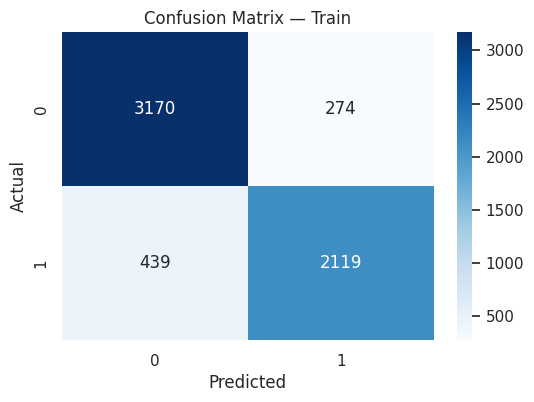

In [34]:
plot_confusion_matrix(y_train, y_train_pred, "Confusion Matrix — Train")

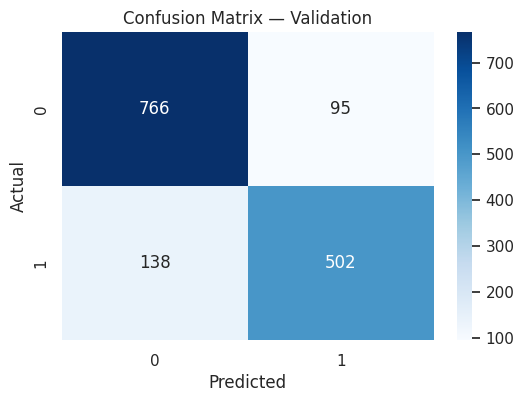

In [35]:
plot_confusion_matrix(y_val, y_val_pred, "Confusion Matrix — Validation")

# Summary: DistilBERT Performance

The DistilBERT model demonstrated strong performance in disaster tweet classification:

- **Training F1-score**: 88%
- **Validation F1-score**: 85%

Now, let's use the trained model to make predictions on the test set and prepare our submission.


# Generate the submission file

In [36]:
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [37]:
sample_submission["target"] = np.argmax(classifier.predict(X_test), axis=1)

102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step


In [38]:
sample_submission.describe()

,id,target
count,3263.000000,3263.000000
mean,5427.152927,0.401471
std,3146.427221,0.490271
min,0.000000,0.000000
25%,2683.000000,0.000000
50%,5500.000000,0.000000
75%,8176.000000,1.000000
max,10875.000000,1.000000


In [39]:
sample_submission.to_csv("submission.csv", index=False)